In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Monte Carlo Simulation to Estimate Probability of High >= (1 + delta)* Open

In [3]:
def open_data(print_head=False, print_shape=False):
    df = pd.read_csv('Data/QQQ_full.csv', header=0, parse_dates=True)
    del df['Unnamed: 0']
    df['Date'] = pd.to_datetime(df['Date'])
    print(max(df['Date']))
    print(min(df['Date']))
    df.sort_values(by='Date', inplace=True)
    df.set_index('Date', inplace=True)
    df['Volume'] = df['Volume'].str.replace(',', '')
    df['Volume'] = df['Volume'].astype(float)
    df = df.dropna()
    if print_shape:
        print(df.shape)
    if print_head:
        print(df.head())
    return df

def plot_data(df, columns = ['Close']):
    plt.figure(figsize=(16, 8))
    for i, col in enumerate(columns):
        plt.subplot(len(columns), 1, i+1)
        plt.plot(df[col], label=col)
        plt.title(col, y=0.5, loc='right')
    plt.show()

2023-11-02 00:00:00
2019-01-02 00:00:00
(1195, 18)
              Open    High     Low   Close      Volume 1-month 3-month  \
Date                                                                     
2019-01-02  150.99  155.75  150.88  154.88  58576672.0    2.40    2.42   
2019-01-03  152.60  153.26  149.49  149.82  74820234.0    2.42    2.41   
2019-01-04  152.18  157.00  151.74  156.23  74709320.0    2.40    2.42   
2019-01-07  156.54  158.86  156.11  158.09  52059328.0    2.42    2.45   
2019-01-08  159.56  160.11  157.20  159.52  49388688.0    2.40    2.46   

           6-month 1-year 2-year 3-year 5-year 7-year 10-year 20-year 30-year  \
Date                                                                            
2019-01-02    2.51   2.60   2.50   2.47   2.49   2.56    2.66    2.83    2.97   
2019-01-03    2.47   2.50   2.39   2.35   2.37   2.44    2.56    2.75    2.92   
2019-01-04    2.51   2.57   2.50   2.47   2.49   2.56    2.67    2.83    2.98   
2019-01-07    2.54   2.58

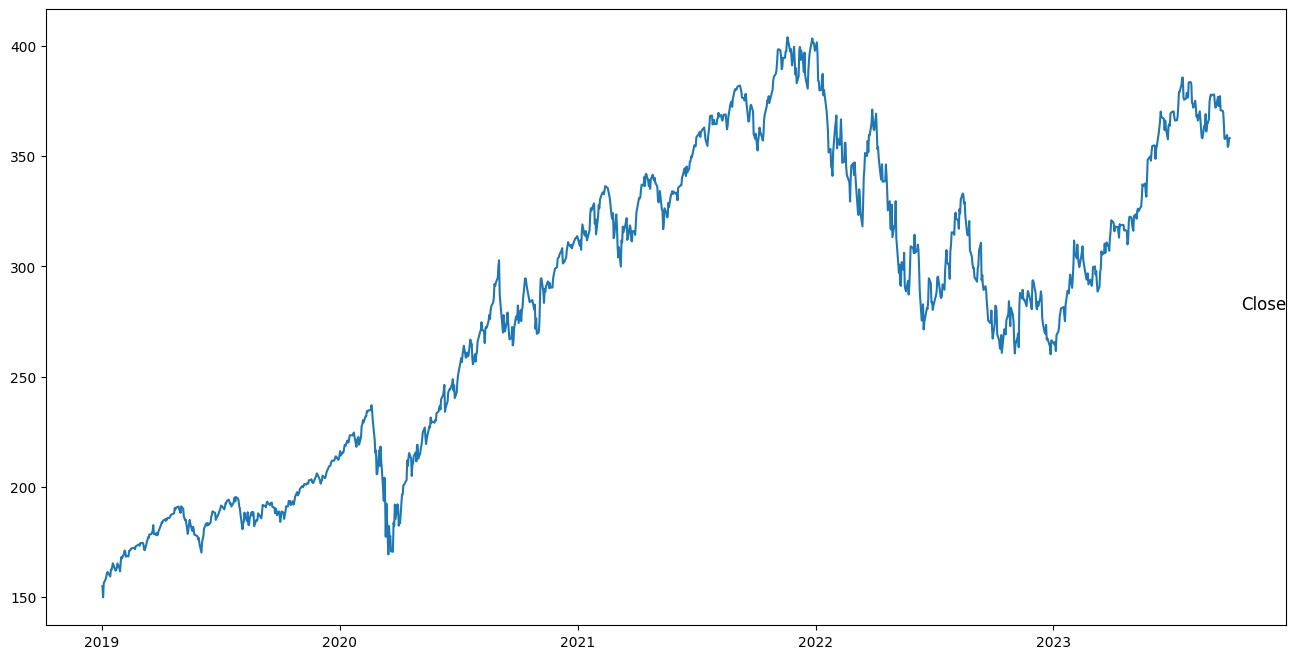

In [4]:
df = open_data(print_head=True, print_shape=True)
plot_data(df)

In [5]:
import math

test_set = df.tail(252)
monte_carlo_set = df.head(df.shape[0] - 252)
total_growth = (monte_carlo_set['High'][len(monte_carlo_set)-1] / monte_carlo_set['High'][1])

#Next, we want to annualize this percentage
#2023-11-02 00:00:00 end
# start 2019-01-02 00:00:00
number_of_years = monte_carlo_set.shape[0] / 252.0
#Second, we can raise the total growth to the inverse of the # of years
#(e.g. ~1/10 at time of writing) to annualize our growth rate
cagr = total_growth ** (1/number_of_years) - 1

#Now that we have the mean annual growth rate above,
#we'll also need to calculate the standard deviation of the
#daily price changes
std_dev = monte_carlo_set['High'].pct_change().std()


number_of_trading_days = 252
annualized_std = std_dev * math.sqrt(number_of_trading_days)

#From here, we have our two inputs needed to generate random
#values in our simulation
print ("cagr (mean returns) : ", str(round(cagr,4)))
print ("std_dev (standard deviation of return : )", str(round(annualized_std,4)))

cagr (mean returns) :  0.1761
std_dev (standard deviation of return : ) 0.2008


/var/folders/wp/r00yf5854pd8dw3f9524hrd80000gn/T/ipykernel_66705/3826562358.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  total_growth = (monte_carlo_set['High'][len(monte_carlo_set)-1] / monte_carlo_set['High'][1])


/var/folders/wp/r00yf5854pd8dw3f9524hrd80000gn/T/ipykernel_66705/1398454281.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  price_series = [monte_carlo_set['High'][len(monte_carlo_set)-1]]


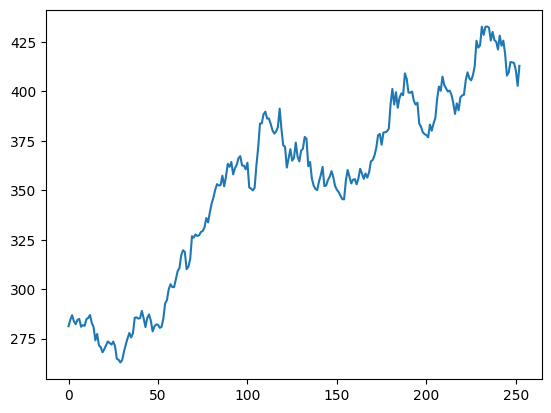

In [6]:
daily_return_percentages = np.random.normal(cagr/number_of_trading_days, std_dev, number_of_trading_days)+1
#Now that we have created a random series of future
#daily return %s, we can simply apply these forward-looking
#to our last stock price in the window, effectively carrying forward
#a price prediction for the next year

#This distribution is known as a 'random walk'

price_series = [monte_carlo_set['High'][len(monte_carlo_set)-1]]

for j in daily_return_percentages:
    price_series.append(price_series[-1] * j)

#Great, now we can plot of single 'random walk' of stock prices
plt.plot(price_series)
plt.show()

/var/folders/wp/r00yf5854pd8dw3f9524hrd80000gn/T/ipykernel_66705/67409671.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  price_series = [monte_carlo_set['High'][len(monte_carlo_set)-1]]


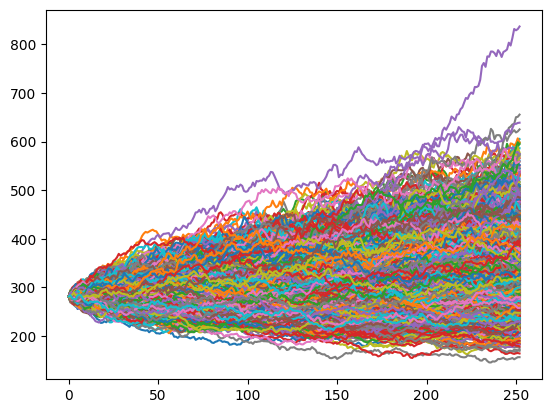

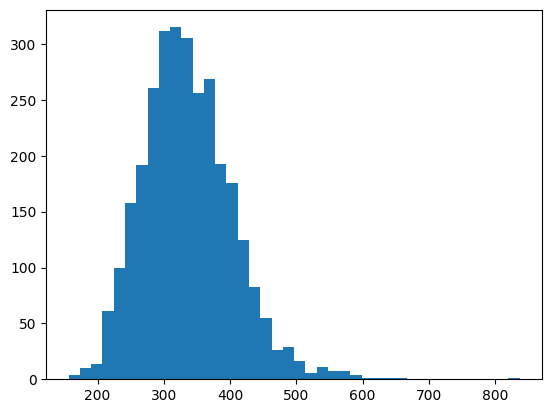

In [7]:
#Now that we've created a single random walk above,
#we can simulate this process over a large sample size to
#get a better sense of the true expected distribution
number_of_trials = 3000
#set up an additional array to collect all possible
#closing prices in last day of window.
#We can toss this into a histogram
#to get a clearer sense of possible outcomes
closing_prices = []
predicted_prices = dict([(k, []) for k in list(test_set.index)])
date = test_set.index

for i in range(number_of_trials):
    index_val = 0
    #calculate randomized return percentages following our normal distribution
    #and using the mean / std dev we calculated above
    daily_return_percentages = np.random.normal(cagr/number_of_trading_days, std_dev, number_of_trading_days)+1
    price_series = [monte_carlo_set['High'][len(monte_carlo_set)-1]]

    for j in daily_return_percentages:
        #extrapolate price out for next year
        price_series.append(price_series[-1] * j) #one random walk one point for each day in year range
        predicted_prices[date[index_val]].append(price_series[-1]*j) #day by day basis
        index_val = index_val + 1

    #append closing prices in last day of window for histogram
    closing_prices.append(price_series[-1])

    #plot all random walks
    plt.plot(price_series)

plt.show()

#plot histogram
plt.hist(closing_prices,bins=40)

plt.show()

In [8]:
mean_end_price = round(np.mean(closing_prices),2)
print("Expected high of day: ", str(mean_end_price)) #actual 355

Expected high of day:  336.3


In [20]:
#to get probability we are going to see how many of the 3000 iterations per day are above (1+delta)*actual Open
#probability calculated as num of iterations where high > (1+delta)*open over total iterations (3000)
probabilities = dict([(k, 0.0) for k in list(test_set.index)])
delta = 0.02 #5 percent
for key, value in predicted_prices.items():
    open_price = test_set[test_set.index == key]['Open'][0] * (1 + delta)
    temp_list = [item for item in value if item >= open_price]
    probabilities[key] = len(temp_list) / len(value) #3000


/var/folders/wp/r00yf5854pd8dw3f9524hrd80000gn/T/ipykernel_66705/3859373925.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  open_price = test_set[test_set.index == key]['Open'][0] * (1 + delta)


In [21]:
#Now let's say we only trade on the days where p > 55%
only_above_55 = {k:v for k,v in probabilities.items() if v > 0.55}

In [23]:
only_above_55

{Timestamp('2022-09-30 00:00:00'): 0.742,
 Timestamp('2022-10-03 00:00:00'): 0.806,
 Timestamp('2022-10-07 00:00:00'): 0.5766666666666667,
 Timestamp('2022-10-10 00:00:00'): 0.772,
 Timestamp('2022-10-11 00:00:00'): 0.8676666666666667,
 Timestamp('2022-10-12 00:00:00'): 0.888,
 Timestamp('2022-10-13 00:00:00'): 0.9703333333333334,
 Timestamp('2022-10-14 00:00:00'): 0.696,
 Timestamp('2022-10-17 00:00:00'): 0.813,
 Timestamp('2022-10-18 00:00:00'): 0.567,
 Timestamp('2022-10-19 00:00:00'): 0.7336666666666667,
 Timestamp('2022-10-20 00:00:00'): 0.7383333333333333,
 Timestamp('2022-10-21 00:00:00'): 0.773,
 Timestamp('2022-10-24 00:00:00'): 0.5946666666666667,
 Timestamp('2022-10-27 00:00:00'): 0.5806666666666667,
 Timestamp('2022-10-28 00:00:00'): 0.674,
 Timestamp('2022-11-02 00:00:00'): 0.619,
 Timestamp('2022-11-03 00:00:00'): 0.8286666666666667,
 Timestamp('2022-11-04 00:00:00'): 0.792,
 Timestamp('2022-11-07 00:00:00'): 0.7883333333333333,
 Timestamp('2022-11-08 00:00:00'): 0.733333

In [25]:
#test on test_set
# now see what the profit would be 
actual_profit = 0
predicted_profit = 0
for ind in test_set.index:
    if test_set['High'][ind] >= (test_set['Open'][ind] * 1.02):
        actual_profit += test_set['High'][ind] - test_set['Open'][ind]
    if ind in only_above_55.keys():
        predicted_profit += test_set['High'][ind] - test_set['Open'][ind]

print(predicted_profit) #higher than actual profit!! $192
print(actual_profit) #148.07


192.64000000000007
148.07999999999996
